## REI602M Machine Learning - Homework 6
### Due: Monday 25.2.2019

**Objectives**: Boosting and stacking algorithms in supervised learning

**Name**: Emil Gauti Friðriksson, **email: ** egf3@hi.is, **collaborators:** (if any)

1\. [AdaBoost classifier, 50 points]

a) [40 points] Implement the AdaBoost algorithm described on page 339 in ESL using small decision trees as base classifiers. Redo the computations for the example of Figure 10.2. Plot the training error as well as test error, and discuss its behavior.

Use the following data set. The features $x_1^{(i)},\ldots,x_{10}^{(i)}$ are standard independent normally distributed variables and the output is defined as $y^{(i)}=1$ if $\sum_{j=1}^{10} (x^{(i)}_j)^2 > 9.34$ and zero otherwise (see comments below).

b) [10 points] Repeat the experiments from a) using a decision tree that captures 2-way feature interactions (3 leaf nodes). How do the results differ from a)?

*Comments*:

1) Use `sklearn.tree.DecisionTreeClassifier` to generate the decision trees. Tree stumps are obtained by setting `max_leaf_nodes=2`. The behaviour of your ensemble classifier may be somewhat different from the one shown in Figure 10.2 in ESL since the implementation of the base tree classifier is different. For this reason you can use e.g. 1000 boosting iterations instead of 400.

2) The `DecisionTreeClassifier.fit` function accepts a vector of sample weights as an optional argument.

3) The training data set in a) is obtained with the function `hw6` below with `hw6(n=1000)`. The test sets are obtained in the same way but using $n=10000$.

4) If $\text{err}_m$ becomes zero we are done.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier


def hw6(n=1000):
    # Toy dataset from page 339 in ESL
    #np.random.seed(1)
    X=np.random.randn(2*n,10)
    y=2*(np.sum(X**2,axis=1)>9.34)-1
    return X,y

def AdaBoostM1(X_train,y_train,X_test,y_test,M,max_ln=2):
    n=X_train.shape[0]
    n2=X_test.shape[0]
    w=np.ones(n)/n
    G_train = np.zeros((n,M))
    G_test = np.zeros((n2,M))
    GG_train = np.zeros((n,M))
    GG_test = np.zeros((n2,M))
    
    for m in range(M):
        G=DecisionTreeClassifier(max_leaf_nodes=max_ln)
        G.fit(X_train,y_train,sample_weight=w)
        y_train_pred = G.predict(X_train)
        I = y_train != y_train_pred
        err= w*I
        error = sum(err)/sum(w)
        if error == 0:
            break
        a = np.log((1-error)/error)
        w = w*np.exp(a*I)
        G_train[:,m] = a*G.predict(X_train)
        G_test[:,m] = a*G.predict(X_test)
        GG_train[:,m] = np.sum(G_train[:,:m],axis=1)
        GG_test[:,m] = np.sum(G_test[:,:m],axis=1)
    
    
    return GG_train, GG_test

X_train,y_train = hw6(n=1000)
X_test,y_test = hw6(n=10000)
n=X_train.shape[0]
n2=X_test.shape[0]
M=1000
trainError=np.zeros(M)
testError=np.zeros(M)
G_train,G_test = AdaBoostM1(X_train,y_train,X_test,y_test,M)
for m in range(M):
    y_train_pred = np.sign(G_train[:,m])
    y_test_pred = np.sign(G_test[:,m])
    error_train = y_train_pred != y_train
    error_test = y_test_pred != y_test
    trainError[m] = np.abs(sum(error_train))/(n)
    testError[m] = np.abs(sum(error_test))/(n2)
    
    

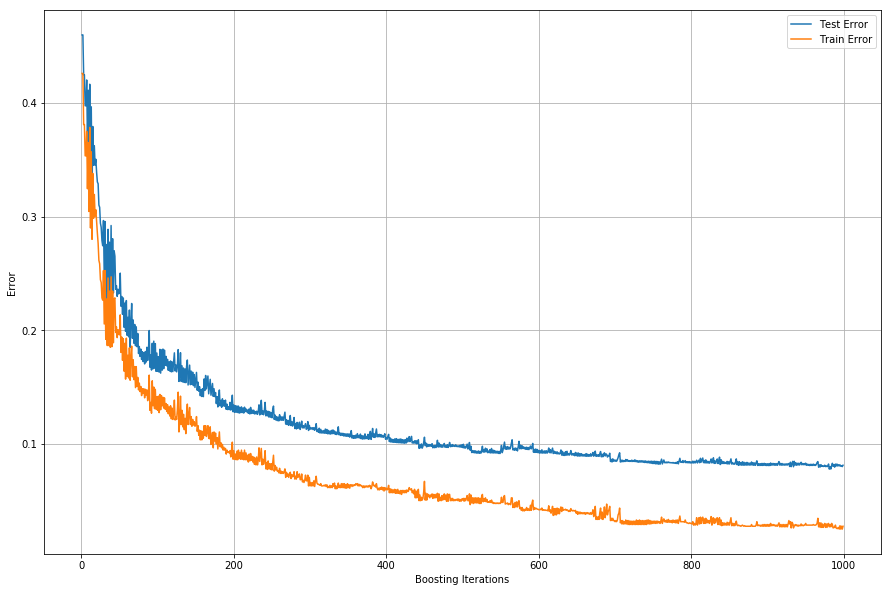

In [31]:
#Plottum myndina:
plt.figure(figsize=(15,10))
plt.plot(np.arange(1,M),testError[1:M],label='Test Error')
plt.plot(np.arange(1,M),trainError[1:M],label='Train Error')
plt.grid()
plt.xlabel('Boosting Iterations')
plt.ylabel('Error')
plt.legend()

Grafið sýnir að Test/Train - error byrjar í háu gildi $\approx 0.4$ sem er lítið betra heldur en að giska af handahófi en það fer hratt lækkandi og nálgast eitthvað gildi.

**(b) Liður**

In [36]:
X_train,y_train = hw6(n=1000)
X_test,y_test = hw6(n=10000)
n=X_train.shape[0]
n2=X_test.shape[0]
M=1000
trainError_b=np.zeros(M)
testError_b=np.zeros(M)
G_train_b,G_test_b = AdaBoostM1(X_train,y_train,X_test,y_test,M,max_ln=3)
for m in range(M):
    y_train_pred_b = np.sign(G_train_b[:,m])
    y_test_pred_b = np.sign(G_test_b[:,m])
    error_train_b = y_train_pred_b != y_train
    error_test_b = y_test_pred_b != y_test
    trainError_b[m] = np.abs(sum(error_train_b))/(n)
    testError_b[m] = np.abs(sum(error_test_b))/(n2)

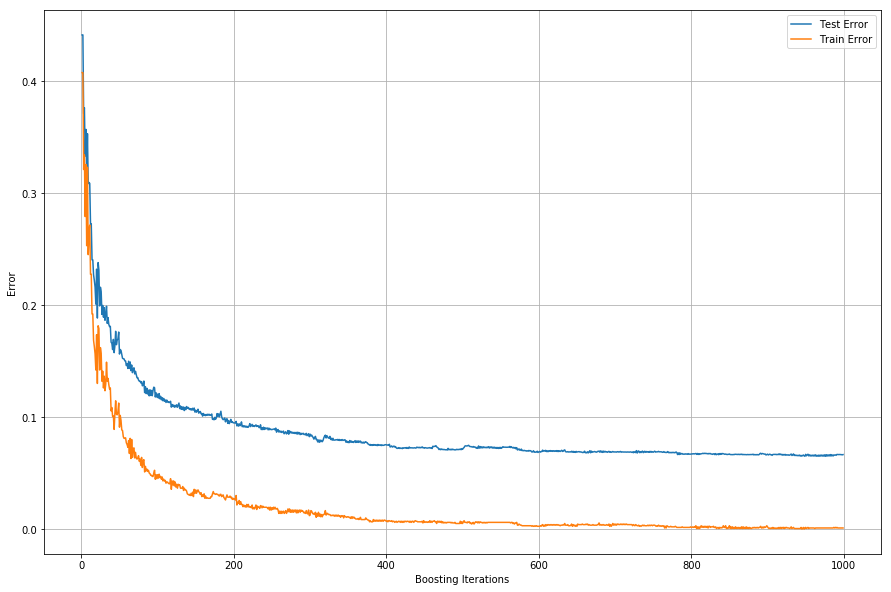

In [37]:
#Plottum myndina:
plt.figure(figsize=(15,10))
plt.plot(np.arange(1,M),testError_b[1:M],label='Test Error')
plt.plot(np.arange(1,M),trainError_b[1:M],label='Train Error')
plt.grid()
plt.xlabel('Boosting Iterations')
plt.ylabel('Error')
plt.legend()

Hér er aðal breytingin hversu hratt villan(error) fellur sem fall af Boosting iteration. Hún fellur töluvert hraðar þegar *max_leaf_note=3* í staðinn fyrir *max_leaf_note=2* eins og í **(a)** lið. Við fáum einnig lægri skekkju á þjálfunargögnunum okkar en skekkjan á prófunargögnunum virðist haldast að mestu leiti sú sama.

2\. [Stacked regression models, 50 points] In this problem you will construct a stacked two-stage regression model for a subset of the Million Song Database (MSD). The data set contains audio features for approximately 500K songs. Each song is represented by 90 features describing its "timbre" that are derived from the sampled recordings. The task is to predict the release year of a song.

A two-stage stacking model has several regression models in stage 1, all trained on the same data set. Predictions from stage 1 models form a new (derived) data set which is used as input to a single regression model in stage 2. This model "blends" predictions from the stage 1 models to create a final prediction, hopefully more accurate than the individual stage 1 predictions.

Your stacked regression model will employ Lasso, ExtraTrees, Random Forests and Gradient boosted trees in stage 1 and a linear regression model in stage 2. Training and testing are performed as follows:

*Training*: Train each model on the training set, using default parameters to begin with, but increase the number of trees for Extra Trees and Random Forests. Construct a training data set for the stage 2 model by sending the *validation* set (not the original training set) through each of the stage 1 models, resulting in an `n_val` by 4 matrix $X_2$. Train a linear regression model for stage 2 on $(X_2, y_\text{val})$.

*Testing*: Send the test data though all the models in stage 1 to obtain an `n_test` by 4 matrix. The stage 2 linear regression model is used to predict the data in this matrix to obtain the final predictions.

a) [32 points] Construct the stacked regression model described above, report its mean-squared error and $R^2$ coefficient on the test set. Report also the mean-squared error of the individual stage 1 models.

b) [8 points] Answer the following questions:

i) Are the individual models doing a good job on the prediction task? Why or why not?

ii) Is the stacking procedure worth the extra effort in your opinion? Why or why not?

iii) Are any of the regression models sensitive to scaling of input data?

iv) Why is it not a good idea to use the original training set to construct the $X_2$ data set for the stage 2 regression model?

c) [10 points] In the spirit of Kaggle, can you improve the results from a) by tuning hyperparameters in level 1, using a different regression model in stage 2 or more training data?

*Comments*:

1) Download the subset of the Million Song Databse from here (210 MB): http://archive.ics.uci.edu/ml/datasets/YearPredictionMSD# (mirror: https://notendur.hi.is/steinng/kennsla/2019/ml/data/YearPredictionMSD.zip)

2) Use the train, validation and test partitions of the data defined in `load_msd.py`

`import load_msd as lmsd
X_train, y_train, X_val, y_val, X_test, y_test = lmsd.get_data(ntrain=10000)`

3) For Extra Trees and Random Forests you can set `n_jobs=-1` to use multiple cores/processors for training and prediction.

**(a)**

In [1]:
# Your stacked regression model will employ Lasso, ExtraTrees, Random Forests 
# and Gradient boosted trees in stage 1 and a linear regression model in stage 2
import load_msd
X_train, y_train, X_val, y_val, X_test, y_test = load_msd.get_data(ntrain=10000)



In [2]:
### STAGE I
import numpy as np
from sklearn import linear_model
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

La = linear_model.Lasso()
Et = ExtraTreesRegressor(n_jobs=-1, n_estimators=500)
Rf = RandomForestRegressor(n_jobs=-1, n_estimators=500)
Gbt = GradientBoostingRegressor()

names = [La,Et,Rf,Gbt]
n_val = X_val.shape[0]
X2_val = np.zeros((n_val,4))
for i in range(4):
    names[i].fit(X_train,y_train)
    X2_val[:,i] = names[i].predict(X_val)

    
### STAGE II

Lr = linear_model.LinearRegression()
Lr.fit(X2_val,y_val)


### TEST DATA
n_test = X_test.shape[0]
X2_test = np.zeros((n_test,4))
for i in range(4):
    X2_test[:,i] = names[i].predict(X_test)


In [3]:
###Report individual test score:
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
names_str = ['Lasso','ExtraTrees', 'RandomForest', 'GradientBoosting']
MSE = np.zeros(5)
R2 = np.zeros(5)
#STAGE I
print('{:<20s} {:<7s} {:<12s} {:<12s}'.format('Model','Stage','R^2', 'MSE'))
print('-'*50)
for i in range(4):
    MSE[i] = mse(y_test,X2_test[:,i])
    R2[i] = r2(y_test,X2_test[:,i])
    print('{:<20s} {:<7s} {:<12f} {:<12f}'.format(names_str[i],'I',R2[i], MSE[i]))
ypred = Lr.predict(X2_test)
MSE[4] = mse(y_test,ypred)
R2[4] = r2(y_test,ypred)
print('{:<20s} {:<7s} {:<12f} {:<12f}'.format('LinearRegression','II',R2[4],MSE[4]))

Model                Stage   R^2          MSE         
--------------------------------------------------
Lasso                I       0.220785     91.414913   
ExtraTrees           I       0.228315     90.531476   
RandomForest         I       0.209047     92.791926   
GradientBoosting     I       0.243151     88.791010   
LinearRegression     II      0.264345     86.304618   


**(b)**

i) Are the individual models doing a good job on the prediction task? Why or why not?

Öll fyrstu fjögur módelin standa sig svipað vel og eru að standa sig ágætlega miðað við verkefnið.

ii) Is the stacking procedure worth the extra effort in your opinion? Why or why not?

Við fáum betri niðurstöður svo já ég tel þetta vera þess virði.

iii) Are any of the regression models sensitive to scaling of input data?

Lasso er nokkuð viðkvæmt fyrir skölun en decision trees(random forest og Extra trees) er það ekki. Gradient boosting er ekki viðkæmt fyrir skölun. Linear regression er mjög viðkvæmt fyrir skölun.

iv) Why is it not a good idea to use the original training set to construct the  X2  data set for the stage 2 regression model?

því þá erum við að nota training gögnin sem við notuðum til að fitta stage I en við viljum ekki fá bias þar sem í Stage I er $Error_{train}<Error_{val}$ 

**(c)**
 In the spirit of Kaggle, can you improve the results from a) by tuning hyperparameters in level 1, using a different regression model in stage 2 or more training data?

Byrjum á að prófa nýja hyperparameters fyrir Stage I

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
La2 = linear_model.Lasso()
Et2 = ExtraTreesRegressor(n_jobs=-1, n_estimators=500)
Rf2 = RandomForestRegressor(n_jobs=-1, n_estimators=500)
Gbt2 = GradientBoostingRegressor()
parametersGbt = {'loss' : ['ls', 'lad', 'huber', 'quantile'], 
              'learning_rate':[0.1,0.4,0.7,1], 'n_estimators' :[10,100,300]}
parametersLa = {'alpha':[0.1,0.3,0.6,0.8,1]}

clfLa = GridSearchCV(La2, parametersLa, cv=5)
clfGbt = GridSearchCV(Gbt, parametersGbt, cv=5)
clfLa.fit(X_train,y_train)
clfGbt.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'loss': ['ls', 'lad', 'huber', 'quantile'], 'learning_rate': [0.1, 0.4, 0.7, 1], 'n_estimators': [10, 100, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [28]:
print('TrainScore Lasso: ',clfLa.score(X_train,y_train))
print('testScore Lasso: ', clfLa.score(X_test,y_test))
print('TrainScore GradientBoost: ',clfGbt.score(X_train,y_train))
print('testScore GradientBoost: ', clfGbt.score(X_test,y_test))

print('Bestu parametrar Lasso:',clfLa.best_params_)
print('Bestu parametrar GradientBoost:',clfGbt.best_params_)

TrainScore:  0.24665509223597157
testScore:  0.22235833724798204
TrainScore:  0.44969610258294157
testScore:  0.254409374190794
Bestu parametrar: {'alpha': 0.3}
Bestu parametrar: {'learning_rate': 0.1, 'loss': 'huber', 'n_estimators': 300}


Notum þessa parametra til að prófa á linearRegression í Stage II

In [30]:
n_val = X_val.shape[0]
X2_val2 = np.zeros((n_val,4))

Et2.fit(X_train,y_train)
Rf2.fit(X_train,y_train)
X2_val2[:,0] = clfLa.predict(X_val)
X2_val2[:,1] = Et2.predict(X_val)
X2_val2[:,2] = Rf2.predict(X_val)
X2_val2[:,3] = clfGbt.predict(X_val)

In [31]:
Lr2 = linear_model.LinearRegression()
Lr2.fit(X2_val2,y_val)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [32]:
n_test = X_test.shape[0]
X2_test2 = np.zeros((n_test,4))
names2 = [clfLa,Et2,Rf2,clfGbt]
for i in range(4):
    X2_test2[:,i] = names2[i].predict(X_test)

In [33]:
###Report individual test score:
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
names_str = ['Lasso','ExtraTrees', 'RandomForest', 'GradientBoosting']
MSE2 = np.zeros(5)
R22 = np.zeros(5)
#STAGE I
print('{:<20s} {:<7s} {:<12s} {:<12s}'.format('Model','Stage','R^2', 'MSE'))
print('-'*50)
for i in range(4):
    MSE2[i] = mse(y_test,X2_test2[:,i])
    R22[i] = r2(y_test,X2_test2[:,i])
    print('{:<20s} {:<7s} {:<12f} {:<12f}'.format(names_str[i],'I',R22[i], MSE2[i]))
ypred2 = Lr2.predict(X2_test2)
MSE2[4] = mse(y_test,ypred2)
R22[4] = r2(y_test,ypred2)
print('{:<20s} {:<7s} {:<12f} {:<12f}'.format('LinearRegression','II',R22[4],MSE2[4]))

Model                Stage   R^2          MSE         
--------------------------------------------------
Lasso                I       0.222358     91.230297   
ExtraTrees           I       0.228145     90.551409   
RandomForest         I       0.210713     92.596431   
GradientBoosting     I       0.254409     87.470177   
LinearRegression     II      0.275475     84.998801   


Sjáum því að við fáum örlítið betri niðurstöður við það að breyta parametrum í stage I

Prófum nú að nota eitthvað annað en Linear Regression, notum SVC og Logistic regression:

In [38]:
from sklearn.svm import SVC
rbf = SVC(kernel='rbf')
rbf.fit(X2_val2,y_val)
print('{:<20s} {:<7s} {:<12s} {:<12s}'.format('Model','Stage','R^2', 'MSE'))
print('-'*50)
ypred_rbf = rbf.predict(X2_test2)
MSE_rbf = mse(y_test,ypred_rbf)
R2_rbf = r2(y_test,ypred_rbf)
print('{:<20s} {:<7s} {:<12f} {:<12f}'.format('SVC','II',R2_rbf,MSE_rbf))

Model                Stage   R^2          MSE         
--------------------------------------------------
SVC                  II      -0.074020    126.000348  


In [40]:
from sklearn.linear_model import LogisticRegression
Logr = LogisticRegression()
Logr.fit(X2_val2,y_val)
print('{:<20s} {:<7s} {:<12s} {:<12s}'.format('Model','Stage','R^2', 'MSE'))
print('-'*50)
ypred_Logr = Logr.predict(X2_test2)
MSE_Logr = mse(y_test,ypred_Logr)
R2_Logr = r2(y_test,ypred_Logr)
print('{:<20s} {:<7s} {:<12f} {:<12f}'.format('Logistic Regr','II',R2_Logr,MSE_Logr))

Model                Stage   R^2          MSE         
--------------------------------------------------
Logistic Regr        II      -0.559512    182.956687  


Ég prófaði hér bæði SVC og Logistic regression en þau gáfu okkur verri niðurstöður en Linear Regression. Skölun gæti hjálpað hér þó.